# Data Preparation

In [1]:
import os
import numpy as np
from typing import Tuple, Dict, List
from tqdm import tqdm
import random

import torch
import torch.nn as nn 
from torch.nn import DataParallel
from torch.optim import Adam, Optimizer

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import matplotlib.pyplot as plt

from imagenette_dataset import ImageNetteDataset, train_val_split
from trainer import train
from models.ResNet import ResNet, ResBlock
from utils import get_random_images, plot_predictions, plot_confusion_matrix

In [2]:
def download_data():
    if not os.path.exists('data'):
        os.makedir('data')

    if not os.listdir('data'):
        !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
        !tar -xzvf 'imagenette2.tgz' -C 'data'

download_data()

In [3]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_ids = [0, 1, 2, 3, 4, 5, 6]
device

device(type='cuda', index=0)

In [4]:
train_dataset, val_dataset = train_val_split(
    ImageNetteDataset(root_dir='data/imagenette2/train'), 
    val_size=0.2)
test_dataset = ImageNetteDataset(root_dir='data/imagenette2/val')

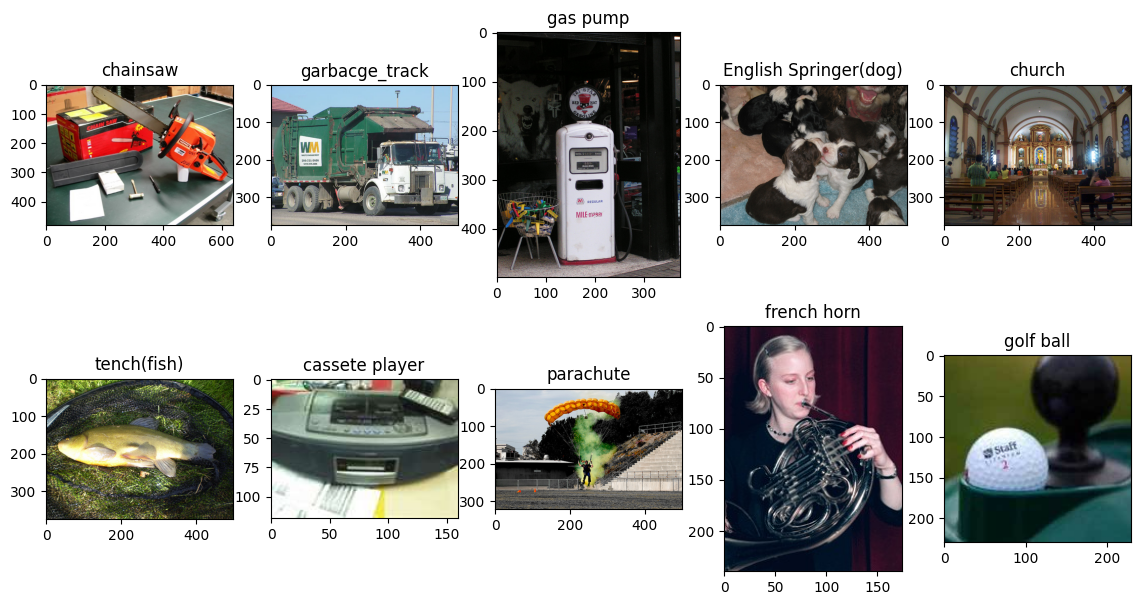

In [5]:
train_dataset.dataset.random_data_examples()

In [6]:
print(f'Train size = {len(train_dataset)}, Validation size = {len(val_dataset)}, Test size = {len(test_dataset)}')

Train size = 7575, Validation size = 1894, Test size = 3925


In [7]:
batch_size = 256
n_workers = 8

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)

# Training

## Standard resnet models

In [8]:
resnet_18 = DataParallel(ResNet(ResBlock, num_layers=18, num_classes=10).to(device), device_ids=device_ids)
resnet_34 = DataParallel(ResNet(ResBlock, num_layers=34, num_classes=10).to(device), device_ids=device_ids)
resnet_50 = DataParallel(ResNet(ResBlock, num_layers=50, num_classes=10).to(device), device_ids=device_ids)
resnet_101 = DataParallel(ResNet(ResBlock, num_layers=101, num_classes=10).to(device), device_ids=device_ids)

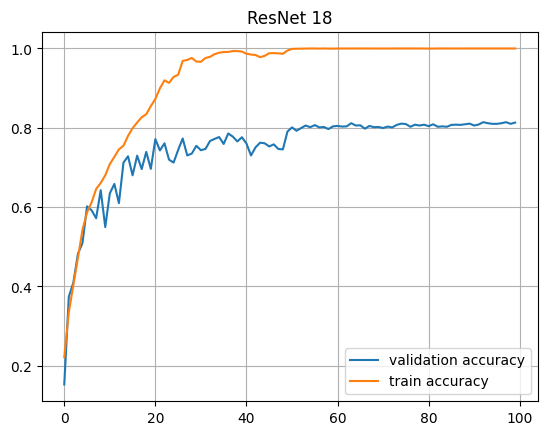

Validation accuracy: 0.813, best_val_acc: 0.814


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s, accuracy=0.794]


Test accuracy of ResNet 18 = 0.7938853503184713


In [10]:
n_epochs = 100
lr= 5*1e-3

criterion = nn.CrossEntropyLoss()

optimizer = Adam(resnet_18.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_18 = train(resnet_18, 
                  train_dataloader, 
                  val_dataloader,
                  test_dataloader,
                  optimizer, 
                  criterion, 
                  device,
                  scheduler, 
                  n_epochs, 
                  title='ResNet 18')

del resnet_18
torch.cuda.empty_cache()

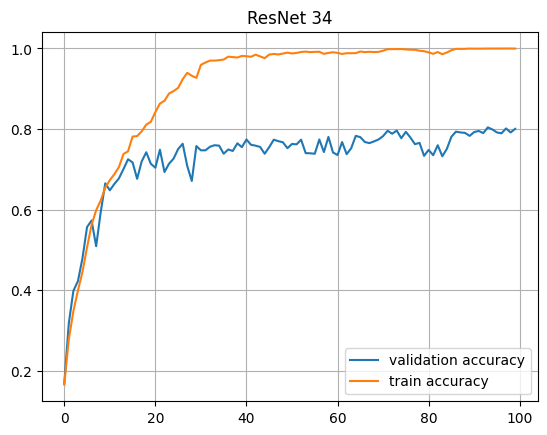

Validation accuracy: 0.800, best_val_acc: 0.804


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s, accuracy=0.793]


Test accuracy of ResNet 34 = 0.7928662420382165


In [11]:
optimizer = Adam(resnet_34.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_34 = train(resnet_34, 
                  train_dataloader, 
                  val_dataloader,
                  test_dataloader,
                  optimizer, 
                  criterion, 
                  device,
                  scheduler, 
                  n_epochs, 
                  title='ResNet 34')

del resnet_34
torch.cuda.empty_cache()

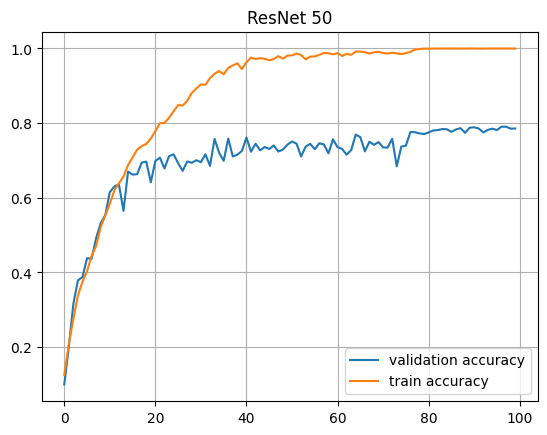

Validation accuracy: 0.786, best_val_acc: 0.790


Testing: 100%|██████████| 16/16 [00:05<00:00,  2.79it/s, accuracy=0.773]


Test accuracy of ResNet 50 = 0.7727388535031847


In [12]:
optimizer = Adam(resnet_50.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_50 = train(resnet_50, 
                  train_dataloader, 
                  val_dataloader,
                  test_dataloader,
                  optimizer, 
                  criterion, 
                  device,
                  scheduler, 
                  n_epochs, 
                  title='ResNet 50')

del resnet_50
torch.cuda.empty_cache()

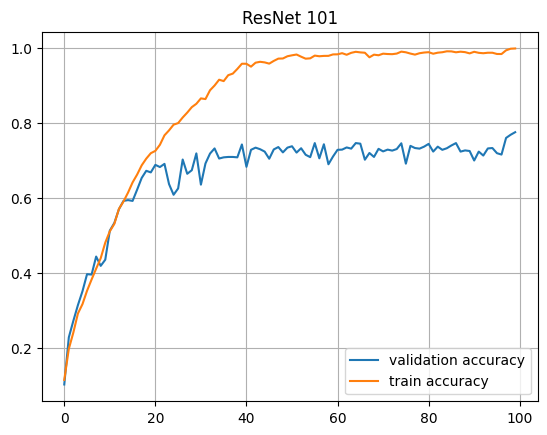

Validation accuracy: 0.776, best_val_acc: 0.776


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s, accuracy=0.749]


Test accuracy of ResNet 101 = 0.7485350318471338


In [13]:
optimizer = Adam(resnet_101.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_101 = train(resnet_101, 
                  train_dataloader, 
                  val_dataloader,
                  test_dataloader,
                  optimizer, 
                  criterion, 
                  device,
                  scheduler, 
                  n_epochs, 
                  title='ResNet 101')

del resnet_101
torch.cuda.empty_cache()

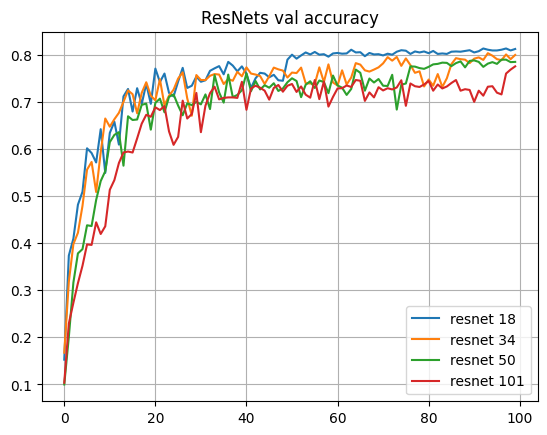

In [14]:
plt.plot(range(n_epochs), result_resnet_18['val_acc'], label='resnet 18')
plt.plot(range(n_epochs), result_resnet_34['val_acc'], label='resnet 34')
plt.plot(range(n_epochs), result_resnet_50['val_acc'], label='resnet 50')
plt.plot(range(n_epochs), result_resnet_101['val_acc'], label='resnet 101')
plt.title(label='ResNets val accuracy')
plt.grid()
plt.legend()
plt.show()

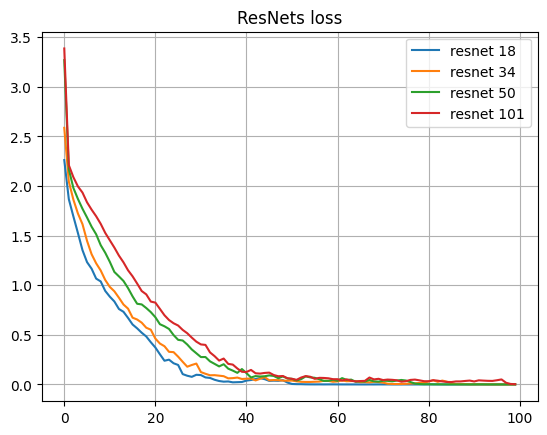

In [15]:
plt.plot(range(n_epochs), result_resnet_18['all_loss'], label='resnet 18')
plt.plot(range(n_epochs), result_resnet_34['all_loss'], label='resnet 34')
plt.plot(range(n_epochs), result_resnet_50['all_loss'], label='resnet 50')
plt.plot(range(n_epochs), result_resnet_101['all_loss'], label='resnet 101')
plt.title(label='ResNets loss')
plt.grid()
plt.legend()
plt.show()

In [31]:
test_acc_18 = result_resnet_18['test_acc']
test_acc_34 = result_resnet_34['test_acc']
test_acc_50 = result_resnet_50['test_acc']
test_acc_101 = result_resnet_101['test_acc']

print(f'Test accuracies \nResNet 18: {test_acc_18} \
    \nResNet 34: {test_acc_34} \
    \nResNet 50: {test_acc_50} \
    \nResNet 101: {test_acc_101}')

Test accuracies 
ResNet 18: 0.7938853503184713     
ResNet 34: 0.7928662420382165     
ResNet 50: 0.7727388535031847     
ResNet 101: 0.7485350318471338


In [40]:
torch.save(result_resnet_18['best_state'], 'resnet18.pt')
torch.save(result_resnet_34['best_state'], 'resnet34.pt')
torch.save(result_resnet_50['best_state'], 'resnet50.pt')
torch.save(result_resnet_101['best_state'], 'resnet101.pt')

## ResNet with 3x3 downsample

In [41]:
resnet_18_3x3 = DataParallel(ResNet(ResBlock, 
                                    num_layers=18, 
                                    num_classes=10, 
                                    downsample_kernel_size=3, 
                                    downsample_padding=1).to(device), 
                             device_ids=device_ids)
resnet_34_3x3 = DataParallel(ResNet(ResBlock, 
                                    num_layers=34, 
                                    num_classes=10,
                                    downsample_kernel_size=3, 
                                    downsample_padding=1).to(device),
                             device_ids=device_ids)
resnet_50_3x3 = DataParallel(ResNet(ResBlock, 
                                    num_layers=50, 
                                    num_classes=10,
                                    downsample_kernel_size=3, 
                                    downsample_padding=1).to(device), 
                             device_ids=device_ids)
resnet_101_3x3 = DataParallel(ResNet(ResBlock, 
                                    num_layers=101, 
                                    num_classes=10,
                                    downsample_kernel_size=3, 
                                    downsample_padding=1).to(device), 
                             device_ids=device_ids)

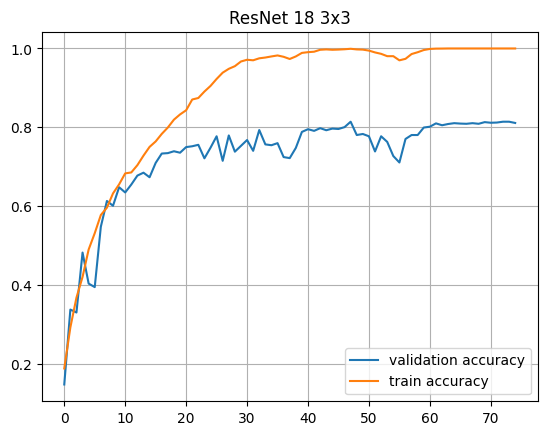

Validation accuracy: 0.811, best_val_acc: 0.814


Testing: 100%|██████████| 16/16 [00:05<00:00,  2.93it/s, accuracy=0.805]


Test accuracy of ResNet 18 3x3 = 0.8050955414012739


In [42]:
n_epochs = 75
lr= 5*1e-3

criterion = nn.CrossEntropyLoss()


optimizer = Adam(resnet_18_3x3.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_18_3x3 = train(resnet_18_3x3, 
                  train_dataloader, 
                  val_dataloader, 
                  test_dataloader,
                  optimizer, 
                  criterion, 
                  device,
                  scheduler, 
                  n_epochs, 
                  title='ResNet 18 3x3')

del resnet_18_3x3
torch.cuda.empty_cache()

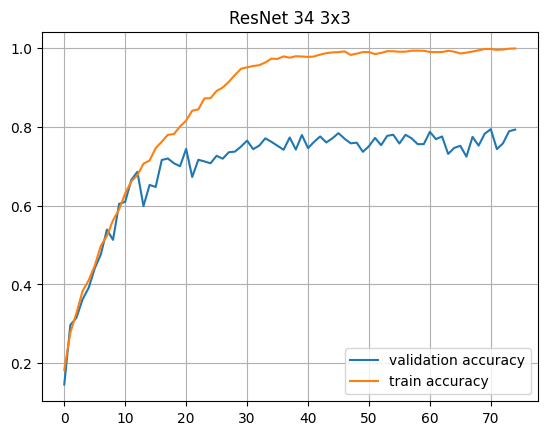

Validation accuracy: 0.793, best_val_acc: 0.794


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s, accuracy=0.771]


Test accuracy of ResNet 34 3x3 = 0.7712101910828025


In [43]:
optimizer = Adam(resnet_34_3x3.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_34_3x3 = train(resnet_34_3x3, 
                  train_dataloader, 
                  val_dataloader, 
                  test_dataloader,
                  optimizer, 
                  criterion, 
                  device,
                  scheduler, 
                  n_epochs, 
                  title='ResNet 34 3x3')

del resnet_34_3x3
torch.cuda.empty_cache()

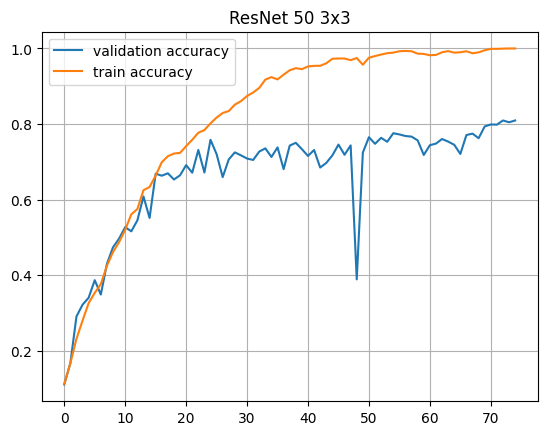

Validation accuracy: 0.809, best_val_acc: 0.809


Testing: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s, accuracy=0.775]


Test accuracy of ResNet 50 3x3 = 0.7752866242038217


In [44]:
optimizer = Adam(resnet_50_3x3.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_50_3x3 = train(resnet_50_3x3, 
                  train_dataloader, 
                  val_dataloader, 
                  test_dataloader,
                  optimizer, 
                  criterion, 
                  device,
                  scheduler, 
                  n_epochs, 
                  title='ResNet 50 3x3')

del resnet_50_3x3
torch.cuda.empty_cache()

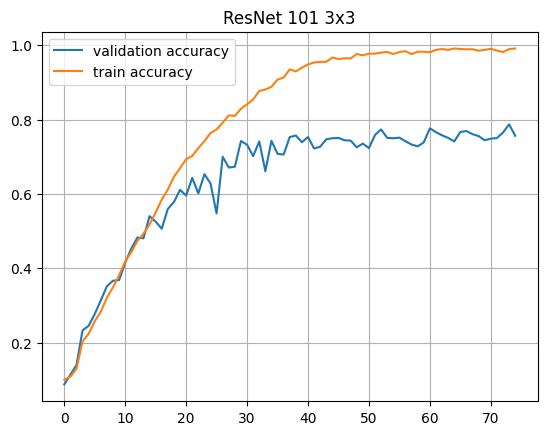

Validation accuracy: 0.757, best_val_acc: 0.787


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s, accuracy=0.739]


Test accuracy of ResNet 101 3x3 = 0.7388535031847133


In [45]:
optimizer = Adam(resnet_101_3x3.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_101_3x3 = train(resnet_101_3x3, 
                  train_dataloader, 
                  val_dataloader, 
                  test_dataloader,
                  optimizer, 
                  criterion, 
                  device,
                  scheduler, 
                  n_epochs, 
                  title='ResNet 101 3x3')

del resnet_101_3x3
torch.cuda.empty_cache()

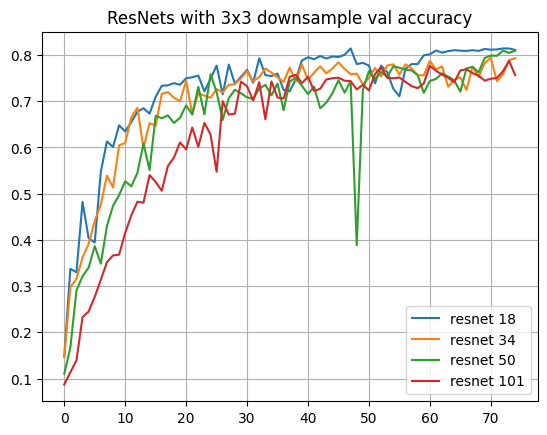

In [46]:
plt.plot(range(n_epochs), result_resnet_18_3x3['val_acc'], label='resnet 18')
plt.plot(range(n_epochs), result_resnet_34_3x3['val_acc'], label='resnet 34')
plt.plot(range(n_epochs), result_resnet_50_3x3['val_acc'], label='resnet 50')
plt.plot(range(n_epochs), result_resnet_101_3x3['val_acc'], label='resnet 101')
plt.title(label='ResNets with 3x3 downsample val accuracy')
plt.grid()
plt.legend()
plt.show()

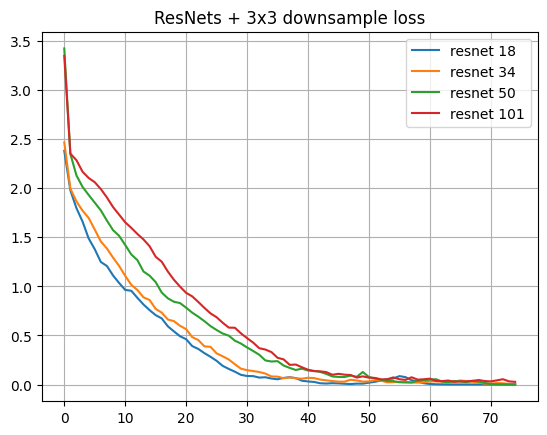

In [47]:
plt.plot(range(n_epochs), result_resnet_18_3x3['all_loss'], label='resnet 18')
plt.plot(range(n_epochs), result_resnet_34_3x3['all_loss'], label='resnet 34')
plt.plot(range(n_epochs), result_resnet_50_3x3['all_loss'], label='resnet 50')
plt.plot(range(n_epochs), result_resnet_101_3x3['all_loss'], label='resnet 101')
plt.title(label='ResNets + 3x3 downsample loss')
plt.grid()
plt.legend()
plt.show()

In [48]:
test_acc_18 = result_resnet_18_3x3['test_acc']
test_acc_34 = result_resnet_34_3x3['test_acc']
test_acc_50 = result_resnet_50_3x3['test_acc']
test_acc_101 = result_resnet_101_3x3['test_acc']

print(f'Test accuracies with 3x3 downsample \nResNet 18: {test_acc_18} \
    \nResNet 34: {test_acc_34} \
    \nResNet 50: {test_acc_50} \
    \nResNet 101: {test_acc_101}')

Test accuracies with 3x3 downsample 
ResNet 18: 0.8050955414012739     
ResNet 34: 0.7712101910828025     
ResNet 50: 0.7752866242038217     
ResNet 101: 0.7388535031847133


In [49]:
torch.save(result_resnet_18_3x3['best_state'], 'resnet18_3x3.pt')
torch.save(result_resnet_34_3x3['best_state'], 'resnet34_3x3.pt')
torch.save(result_resnet_50_3x3['best_state'], 'resnet50_3x3.pt')
torch.save(result_resnet_101_3x3['best_state'], 'resnet101_3x3.pt')

## ResNet with 3x3 downsample + c and d tweaks

In [50]:
resnet_18_3x3_cd = DataParallel(ResNet(ResBlock, 
                                    num_layers=18, 
                                    num_classes=10, 
                                    use_resnet_c=True, 
                                    use_resnet_d=True,
                                    downsample_kernel_size=3, 
                                    downsample_padding=1).to(device), 
                             device_ids=device_ids)
resnet_34_3x3_cd = DataParallel(ResNet(ResBlock, 
                                    num_layers=34, 
                                    num_classes=10, 
                                    use_resnet_c=True, 
                                    use_resnet_d=True,
                                    downsample_kernel_size=3, 
                                    downsample_padding=1).to(device),
                             device_ids=device_ids)
resnet_50_3x3_cd = DataParallel(ResNet(ResBlock, 
                                    num_layers=50, 
                                    num_classes=10, 
                                    use_resnet_c=True, 
                                    use_resnet_d=True,
                                    downsample_kernel_size=3, 
                                    downsample_padding=1).to(device), 
                             device_ids=device_ids)
resnet_101_3x3_cd = DataParallel(ResNet(ResBlock, 
                                    num_layers=101, 
                                    num_classes=10, 
                                    use_resnet_c=True, 
                                    use_resnet_d=True,
                                    downsample_kernel_size=3, 
                                    downsample_padding=1).to(device), 
                             device_ids=device_ids)

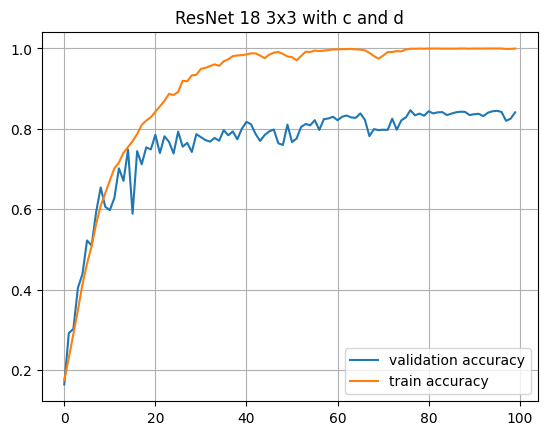

Validation accuracy: 0.841, best_val_acc: 0.846


Testing: 100%|██████████| 16/16 [00:05<00:00,  2.87it/s, accuracy=0.826]


Test accuracy of ResNet 18 3x3 with c and d = 0.8257324840764331


In [51]:
n_epochs = 100
lr= 5*1e-3

criterion = nn.CrossEntropyLoss()

optimizer = Adam(resnet_18_3x3_cd.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_18_3x3_cd = train(resnet_18_3x3_cd, 
                  train_dataloader, 
                  val_dataloader, 
                  test_dataloader,
                  optimizer, 
                  criterion, 
                  device,
                  scheduler, 
                  n_epochs, 
                  title='ResNet 18 3x3 with c and d')

del resnet_18_3x3_cd
torch.cuda.empty_cache()

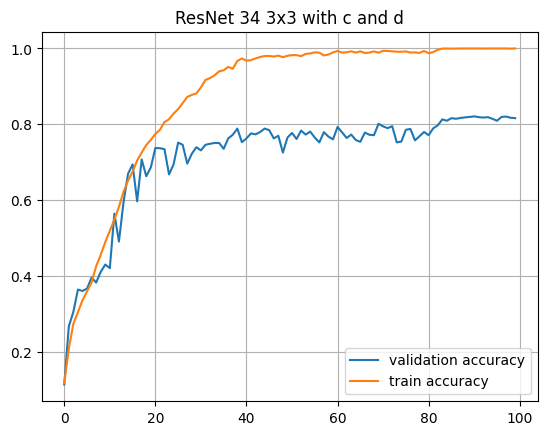

Validation accuracy: 0.816, best_val_acc: 0.821


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s, accuracy=0.809]


Test accuracy of ResNet 34 3x3 with c and d = 0.8089171974522293


In [52]:
optimizer = Adam(resnet_34_3x3_cd.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_34_3x3_cd = train(resnet_34_3x3_cd, 
                  train_dataloader, 
                  val_dataloader, 
                  test_dataloader,
                  optimizer, 
                  criterion, 
                  device,
                  scheduler, 
                  n_epochs, 
                  title='ResNet 34 3x3 with c and d')

del resnet_34_3x3_cd
torch.cuda.empty_cache()

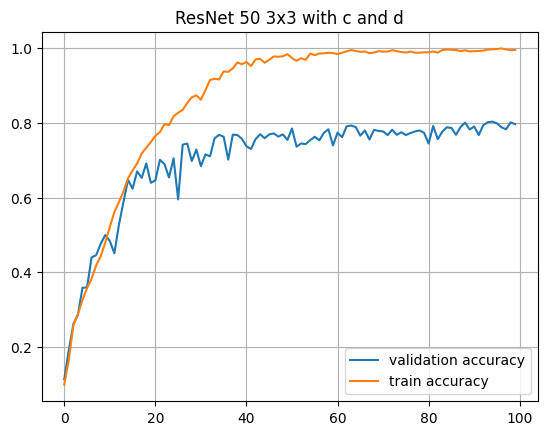

Validation accuracy: 0.796, best_val_acc: 0.803


Testing: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s, accuracy=0.775]


Test accuracy of ResNet 50 3x3 with c and d = 0.7752866242038217


In [53]:
optimizer = Adam(resnet_50_3x3_cd.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_50_3x3_cd = train(resnet_50_3x3_cd, 
                  train_dataloader, 
                  val_dataloader, 
                  test_dataloader,
                  optimizer, 
                  criterion, 
                  device,
                  scheduler, 
                  n_epochs, 
                  title='ResNet 50 3x3 with c and d')

del resnet_50_3x3_cd
torch.cuda.empty_cache()

In [55]:
test_acc_18 = result_resnet_18_3x3_cd['test_acc']
test_acc_34 = result_resnet_34_3x3_cd['test_acc']
test_acc_50 = result_resnet_50_3x3_cd['test_acc']

print(f'Test accuracies with 3x3 downsample + c and d tweaks \nResNet 18: {test_acc_18} \
    \nResNet 34: {test_acc_34} \
    \nResNet 50: {test_acc_50}')

Test accuracies with 3x3 downsample + c and d tweaks 
ResNet 18: 0.8257324840764331     
ResNet 34: 0.8089171974522293     
ResNet 50: 0.7752866242038217


In [56]:
torch.save(result_resnet_18_3x3_cd['best_state'], 'resnet18_3x3_cd.pt')
torch.save(result_resnet_34_3x3_cd['best_state'], 'resnet34_3x3_cd.pt')
torch.save(result_resnet_50_3x3_cd['best_state'], 'resnet50_3x3_cd.pt')

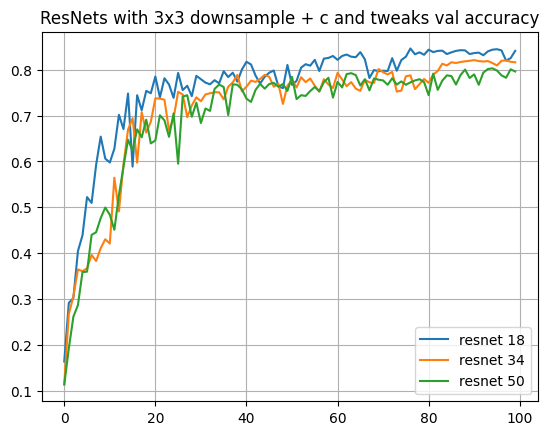

In [57]:
plt.plot(range(n_epochs), result_resnet_18_3x3_cd['val_acc'], label='resnet 18')
plt.plot(range(n_epochs), result_resnet_34_3x3_cd['val_acc'], label='resnet 34')
plt.plot(range(n_epochs), result_resnet_50_3x3_cd['val_acc'], label='resnet 50')
plt.title(label='ResNets with 3x3 downsample + c and tweaks val accuracy')
plt.grid()
plt.legend()
plt.show()

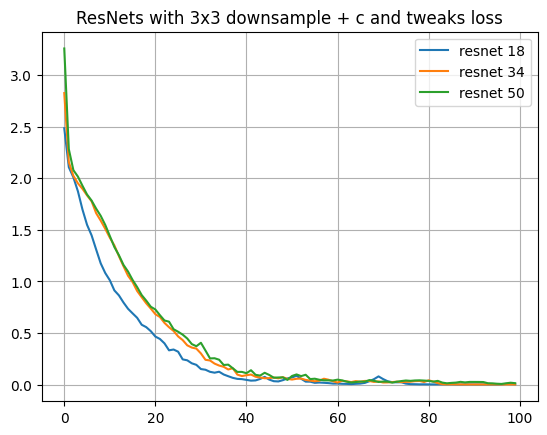

In [58]:
plt.plot(range(n_epochs), result_resnet_18_3x3_cd['all_loss'], label='resnet 18')
plt.plot(range(n_epochs), result_resnet_34_3x3_cd['all_loss'], label='resnet 34')
plt.plot(range(n_epochs), result_resnet_50_3x3_cd['all_loss'], label='resnet 50')
plt.title(label='ResNets with 3x3 downsample + c and tweaks loss')
plt.grid()
plt.legend()
plt.show()

## ResNet 18 with c and d tweaks without 3x3 downsample

In [9]:
resnet_18_cd = DataParallel(ResNet(ResBlock, 
                                    num_layers=18, 
                                    num_classes=10, 
                                    use_resnet_c=True, 
                                    use_resnet_d=True).to(device), 
                             device_ids=device_ids)

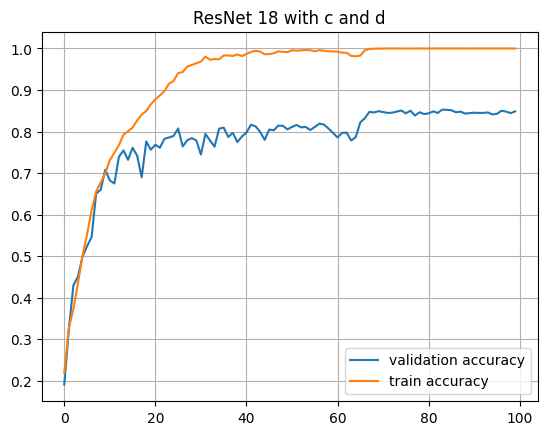

Validation accuracy: 0.848, best_val_acc: 0.853


Testing: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s, accuracy=0.837]


Test accuracy of ResNet 18 with c and d = 0.837452229299363


In [10]:
n_epochs = 100
lr= 5*1e-3

criterion = nn.CrossEntropyLoss()

optimizer = Adam(resnet_18_cd.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_18_cd = train(resnet_18_cd, 
                  train_dataloader, 
                  val_dataloader, 
                  test_dataloader,
                  optimizer, 
                  criterion, 
                  device,
                  scheduler, 
                  n_epochs, 
                  title='ResNet 18 with c and d')

del resnet_18_cd
torch.cuda.empty_cache()

In [11]:
torch.save(result_resnet_18_cd['best_state'], 'resnet18_cd.pt')

# Plot models predictions

In [12]:
resnet_18 = DataParallel(ResNet(ResBlock, num_layers=18, num_classes=10).to(device), device_ids=device_ids)
resnet_18_3x3 = DataParallel(ResNet(ResBlock, 
                                    num_layers=18, 
                                    num_classes=10, 
                                    downsample_kernel_size=3, 
                                    downsample_padding=1).to(device), 
                             device_ids=device_ids)
resnet_18_cd = DataParallel(ResNet(ResBlock, 
                                    num_layers=18, 
                                    num_classes=10, 
                                    use_resnet_c=True, 
                                    use_resnet_d=True).to(device), 
                             device_ids=device_ids)
resnet_18_3x3_cd = DataParallel(ResNet(ResBlock, 
                                    num_layers=18, 
                                    num_classes=10, 
                                    use_resnet_c=True, 
                                    use_resnet_d=True,
                                    downsample_kernel_size=3, 
                                    downsample_padding=1).to(device), 
                             device_ids=device_ids)

resnet_18.load_state_dict(torch.load('resnet18.pt'))
resnet_18_3x3.load_state_dict(torch.load('resnet18_3x3.pt'))
resnet_18_cd.load_state_dict(torch.load('resnet18_cd.pt'))
resnet_18_3x3_cd.load_state_dict(torch.load('resnet18_3x3_cd.pt'))

<All keys matched successfully>

Возьмем самые топовые модели из каждой подгруппы и посмотрим на их предсказания

In [15]:
images = get_random_images()

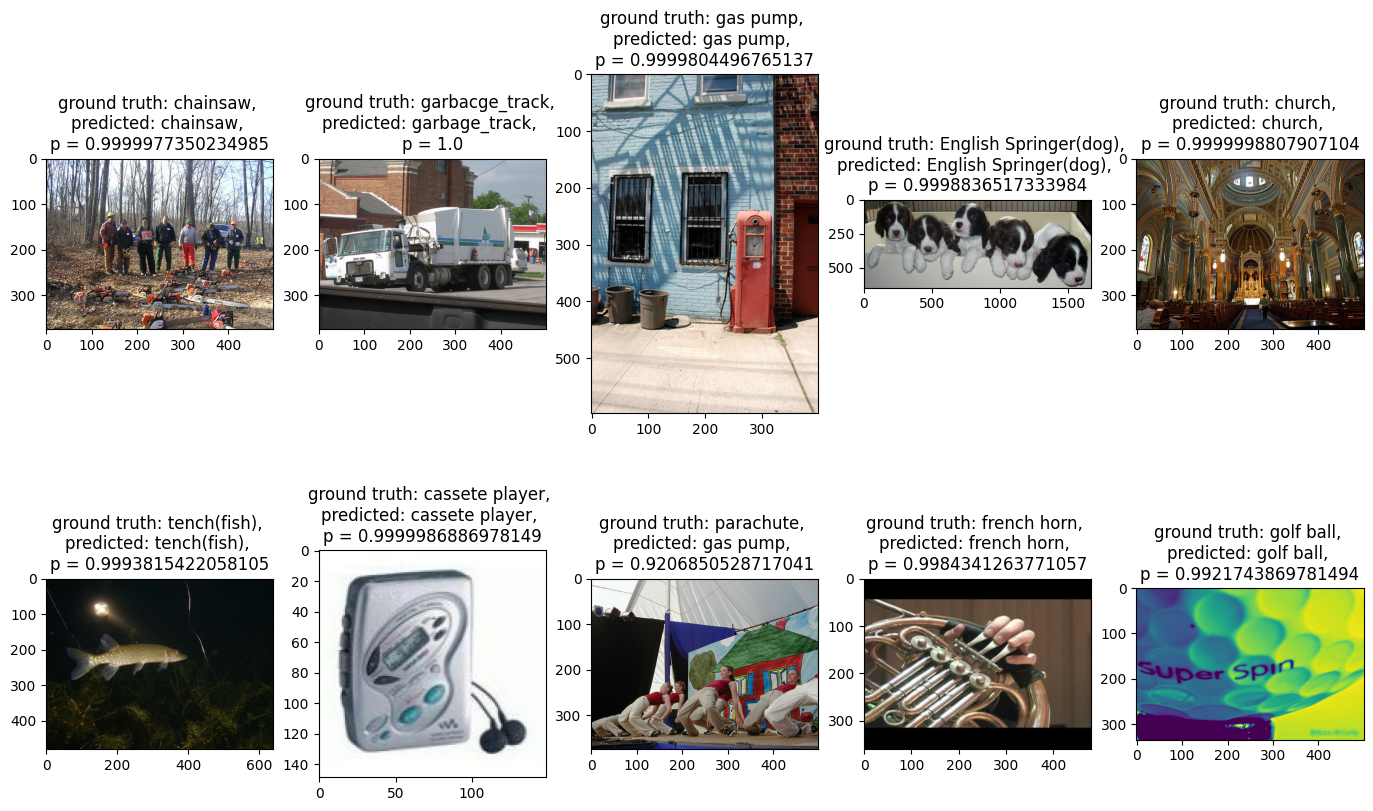

In [16]:
plot_predictions(resnet_18, images, device)

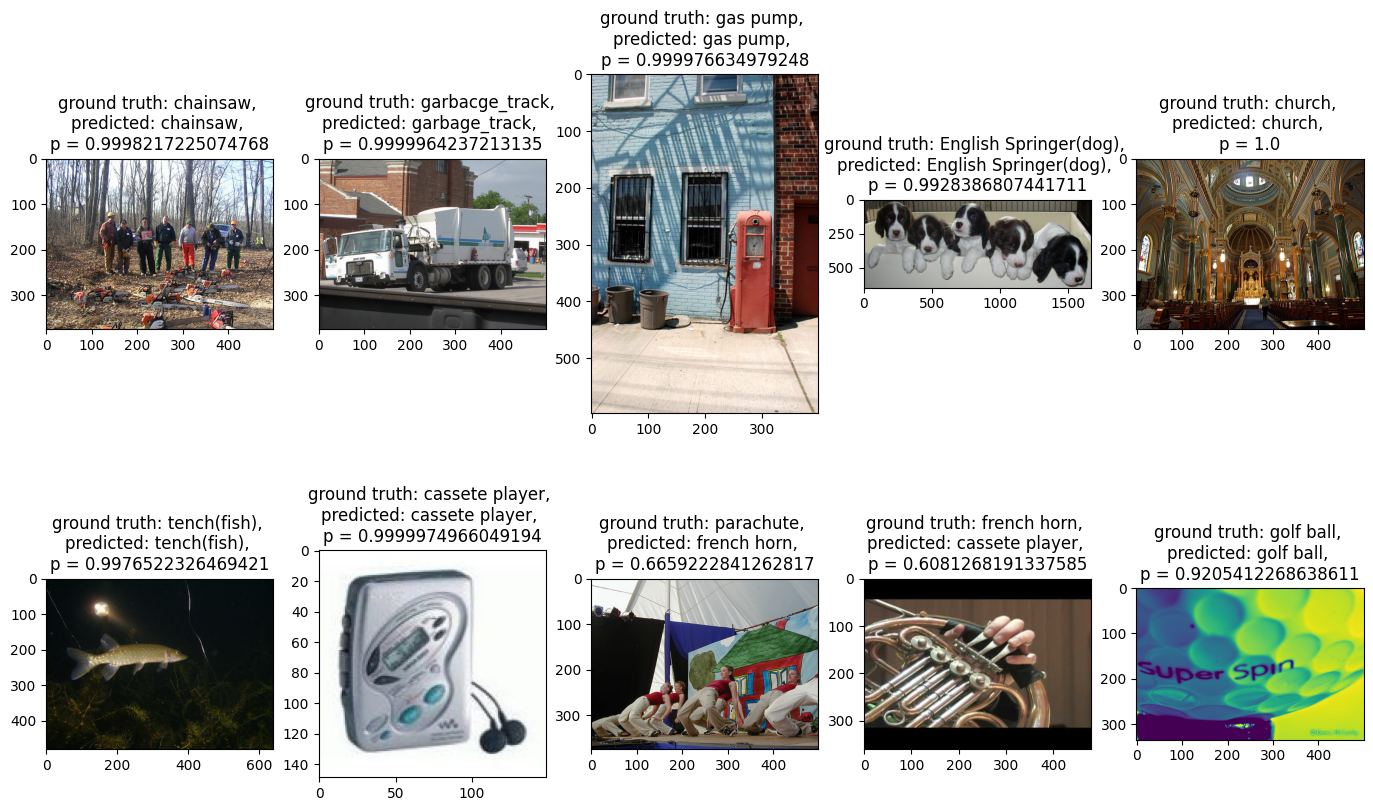

In [17]:
plot_predictions(resnet_18_3x3, images, device)

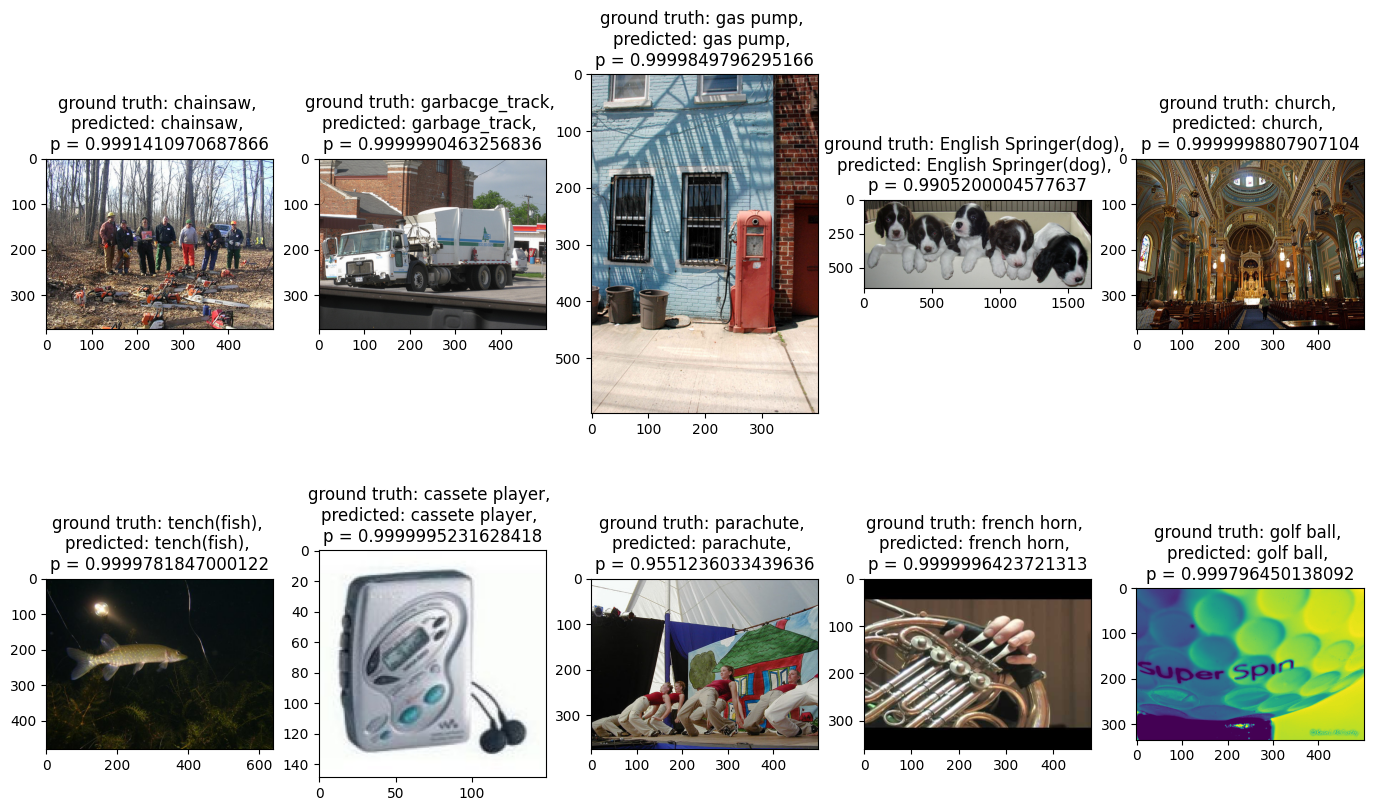

In [18]:
plot_predictions(resnet_18_cd, images, device)

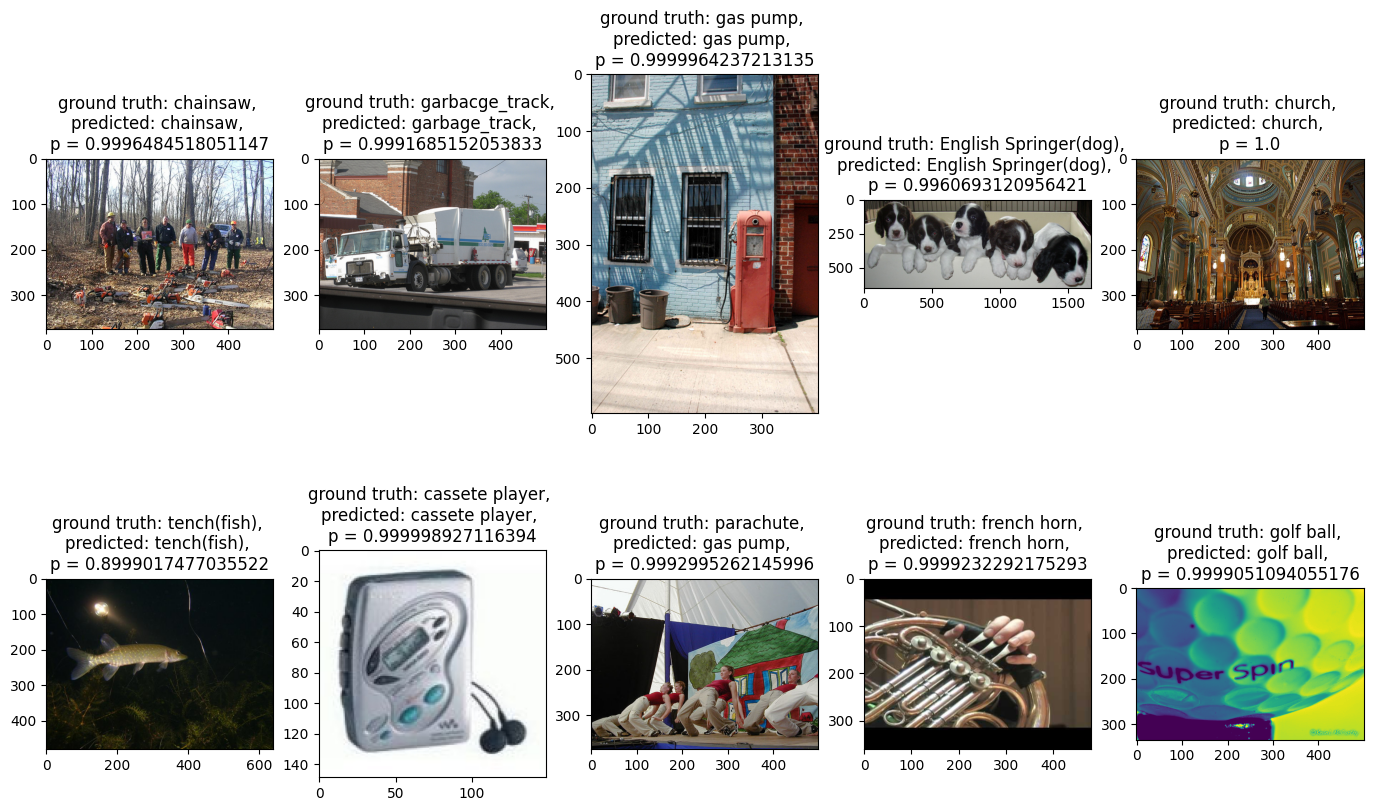

In [19]:
plot_predictions(resnet_18_3x3_cd, images, device)